[View in Colaboratory](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/xy2rgb.ipynb)

##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Compositional Pattern Producing Networks for Feature Visualization

This notebook uses [**Lucid**](https://github.com/tensorflow/lucid) to produce aesthetically pleasing feature visualizations using a [Differentiable Image Parameterization](https://distill.pub/2018/differentiable-parameterizations/#section-xy2rgb) called a **Compositional Pattern Producing Network** (CPPN).

![](https://storage.googleapis.com/tensorflow-lucid/notebooks/xy2rgb/cppn-header.jpg)

This notebook additionally demonstrates:

* rendering videos of the training process of the CPPN generating the visualizations,
* rendering videos of interpolating between sets of learned CPPN parameters
* rendering high resolution visualizations from a set of CPPN parameters.


This notebook doesn't introduce the abstractions behind lucid; you may wish to also read the [Lucid tutorial](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb).

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install, Import, and load a model

In [1]:
!pip install "lucid>=0.3.11"
#!pip install --quiet git+https://github.com/tensorflow/lucid.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# For video rendering
!apt install ffmpeg
!pip uninstall -q -y moviepy # this is to rebuild the moviepy with ffmpeg
!pip install -q moviepy
#!imageio_download_bin ffmpeg # no longer necessary

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 KB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 32.0 MB/s eta 0:00:00


In [3]:
from __future__ import print_function
import io
import string
import numpy as np
import PIL
import base64
from glob import glob

import matplotlib.pylab as pl

import tensorflow as tf
import tf_slim as slim

from IPython.display import clear_output, Image, display, HTML

import moviepy.editor as mpy
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


from google.colab import files

In [4]:
from lucid.modelzoo import vision_models
from lucid.misc.io import show, save, load
from lucid.optvis import objectives
from lucid.optvis import render
from lucid.misc.tfutil import create_session

In [5]:
model = vision_models.InceptionV1()
model.load_graphdef()

## Setting up the CPPN 

In [6]:
def composite_activation(x):
  x = tf.atan(x)
  # Coefficients computed by:
  #   def rms(x):
  #     return np.sqrt((x*x).mean())
  #   a = np.arctan(np.random.normal(0.0, 1.0, 10**6))
  #   print(rms(a), rms(a*a))
  return tf.concat([x/0.67, (x*x)/0.6], -1)


def composite_activation_unbiased(x):
  x = tf.atan(x)
  # Coefficients computed by:
  #   a = np.arctan(np.random.normal(0.0, 1.0, 10**6))
  #   aa = a*a
  #   print(a.std(), aa.mean(), aa.std())
  return tf.concat([x/0.67, (x*x-0.45)/0.396], -1)


def relu_normalized(x):
  x = tf.nn.relu(x)
  # Coefficients computed by:
  #   a = np.random.normal(0.0, 1.0, 10**6)
  #   a = np.maximum(a, 0.0)
  #   print(a.mean(), a.std())
  return (x-0.40)/0.58


def image_cppn(
    size,
    num_output_channels=3,
    num_hidden_channels=24,
    num_layers=8,
    activation_fn=composite_activation,
    normalize=False):
  r = 3.0**0.5  # std(coord_range) == 1.0
  coord_range = tf.linspace(-r, r, size)
  y, x = tf.meshgrid(coord_range, coord_range, indexing='ij')
  net = tf.expand_dims(tf.stack([x, y], -1), 0)  # add batch dimension

  with slim.arg_scope([slim.conv2d], kernel_size=1, activation_fn=None):
    for i in range(num_layers):
      in_n = int(net.shape[-1])
      net = slim.conv2d(
          net, num_hidden_channels,
          # this is untruncated version of tf.variance_scaling_initializer
          weights_initializer=tf.random_normal_initializer(0.0, np.sqrt(1.0/in_n)),
      )
      if normalize:
        net = slim.instance_norm(net)
      net = activation_fn(net)

    rgb = slim.conv2d(net, num_output_channels, activation_fn=tf.nn.sigmoid,
                      weights_initializer=tf.zeros_initializer())
  return rgb

Estimating the number of parameters of CPPN.

In [7]:
with tf.Graph().as_default():
  image_cppn(224)
  variables = tf.compat.v1.get_collection('variables')
  param_n = sum([v.shape.num_elements() for v in variables])
  print('CPPN parameter count:', param_n)

  warnings.warn('`layer.apply` is deprecated and '



CPPN parameter count: 8451


Let's quickly sanity check that this CPPN can learn to produce an image with the properties we expect it to.
As a simplistic test we try to fit the XOR function by imposing a loss on four corner points of the image.

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x7fe231a57280>



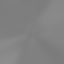
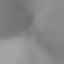
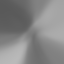
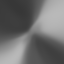
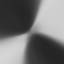
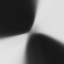
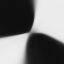
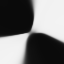
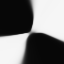
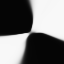

In [8]:
cppn_f = lambda: image_cppn(64)
optimizer = tf.compat.v1.train.AdamOptimizer(0.01)

def xor_objective(T):
  a = T('input')[0]
  return -(tf.square(a[0, 0])      + tf.square(a[-1, -1]) + 
           tf.square(1.0-a[-1, 0]) + tf.square(1.0-a[0, -1]))

vis = render.render_vis(model, xor_objective, param_f=cppn_f, optimizer=optimizer, transforms=[], thresholds=range(10), verbose=False)
show(vis)

That looks reasonable enough!
Let's move on to our original goal: Feature Visualizations

# Feature Visualization

Let's use our new CPPN to produce one of the feature visualizations similar to those in the header image:

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x7fe231a4e4f0>



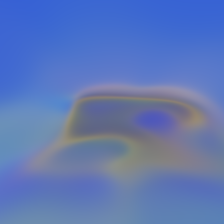
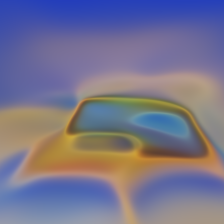
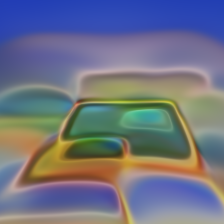
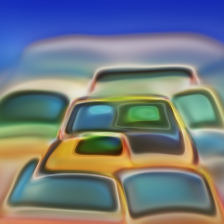
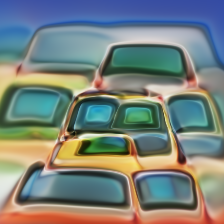

In [9]:
def render_feature(
    cppn_f = lambda: image_cppn(224),
    optimizer = tf.compat.v1.train.AdamOptimizer(0.005),
    objective = objectives.channel("mixed4b_3x3_pre_relu", 77)):
  vis = render.render_vis(model, objective, param_f=cppn_f, optimizer=optimizer, transforms=[], thresholds=[2**i for i in range(5,10)], verbose=False)
  show(vis)

render_feature()

### Varying the activation function

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x7fe2a3f66160>



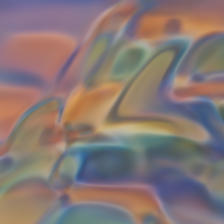
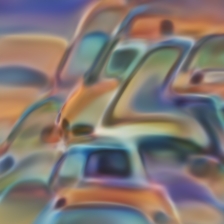
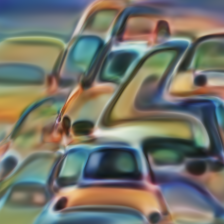
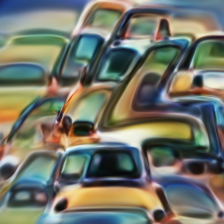
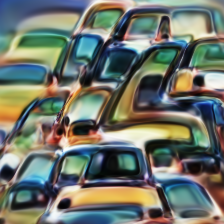

In [10]:
render_feature(
    cppn_f=lambda: image_cppn(224, activation_fn=composite_activation_unbiased))

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x7fe1cc28bd90>



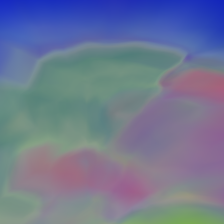
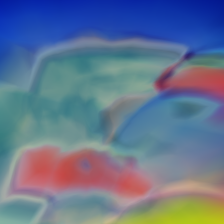
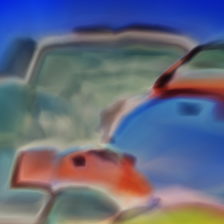
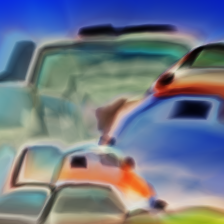
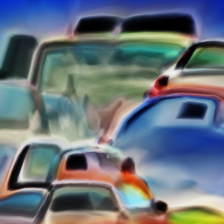

In [11]:
render_feature(
    cppn_f=lambda: image_cppn(224, activation_fn=relu_normalized))

render vis graph: <tensorflow.python.framework.ops.Graph object at 0x7fe2202bd4c0>



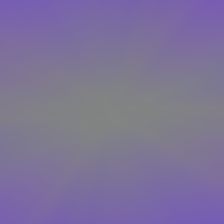
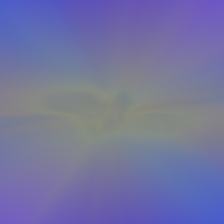
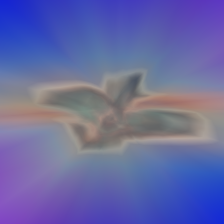
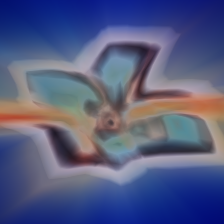
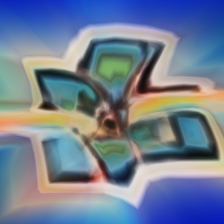

In [12]:
render_feature(
    cppn_f=lambda: image_cppn(224, activation_fn=tf.abs))

# Video of the training process

The following `render_story` function accomplishes a bunch of things: it sets up the optimization problem, saves out frames to a video at each step of the optimization, and finally saves out the weights and the final optimization result.

In [13]:
from lucid.misc.io.serialize_array import _normalize_array


def render_story(obj_str, lr=0.004, step_n=512,
                 normalize=False,
                 activation_fn=composite_activation):
  sess = create_session()

  # Set up optimization problem
  size = 224
  t_size = tf.compat.v1.placeholder_with_default(size, [])
  T = render.make_vis_T(
      model, obj_str, 
      param_f=lambda: image_cppn(
          t_size, normalize=normalize, activation_fn=activation_fn),
      transforms=[],
      optimizer=tf.compat.v1.train.AdamOptimizer(lr),
  )
  tf.compat.v1.global_variables_initializer().run()

  # Prepare video writer and filenames
  subst = {ord(':'):'_', ord('/'):'_'}
  out_name = 'xy2rgb_' + obj_str.translate(subst)
  video_fn = out_name + '.mp4'
  writer = FFMPEG_VideoWriter(video_fn, (size, size), 60.0)

  # Optimization loop
  try:
    for i in range(step_n):
      _, loss, img = sess.run([T("vis_op"), T("loss"), T("input")])
      writer.write_frame(_normalize_array(img))
      if i > 0 and i % 50 == 0:
        clear_output()
        print("%d / %d  score: %f"%(i, step_n, loss))
        show(img)
  except KeyboardInterrupt:
    pass
  finally:
    writer.close()

  # Show the resulting video
  clear_output()
  display(mpy.ipython_display(video_fn, height=400))

  # Save trained variables
  train_vars = sess.graph.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES)
  params = np.array(sess.run(train_vars), object)
  save(params, out_name + '.npy')

  # Save final image
  final_img = T("input").eval({t_size: 400})
  save(final_img, out_name+'.jpg', quality=90)

In [14]:
render_story('mixed4b_pool_reduce_pre_relu:16', )

In [15]:
render_story('mixed4a_pool_reduce_pre_relu:52')

### More interesting patterns to try

In [ ]:
render_story('mixed4c_pool_reduce_pre_relu:5')

In [ ]:
render_story('softmax0_pre_activation/matmul:316')

In [ ]:
render_story('mixed4b_3x3_pre_relu:77')

In [ ]:
render_story('mixed4d_3x3_bottleneck_pre_relu:114')

In [ ]:
render_story('mixed4e_3x3_pre_relu:120')

In [ ]:
render_story('head0_bottleneck_pre_relu:0')

In [ ]:
render_story('mixed4d_3x3_bottleneck_pre_relu:139')

# Arbitrary resolution images

In [59]:
sess = create_session()
t_size = tf.compat.v1.placeholder_with_default(224, [])
t_image = image_cppn(t_size)

train_vars = sess.graph.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES)
#tf.compat.v1.variables_initializer(train_vars).run()
tf.compat.v1.global_variables_initializer().run()

# for some reason this original functin does not seems to cause variables to be assigned
def render_params_orig(params, size=224):
  feed_dict = dict(zip(train_vars, params))
  feed_dict[t_size] = size
  return sess.run(t_image, feed_dict)[0]

def render_params(params, size=224):
  for i, train_var in enumerate(train_vars):
    train_var.load(params[i], sess)
  feed_dict = {}
  feed_dict[t_size] = size
  return sess.run(t_image, feed_dict=feed_dict)[0]


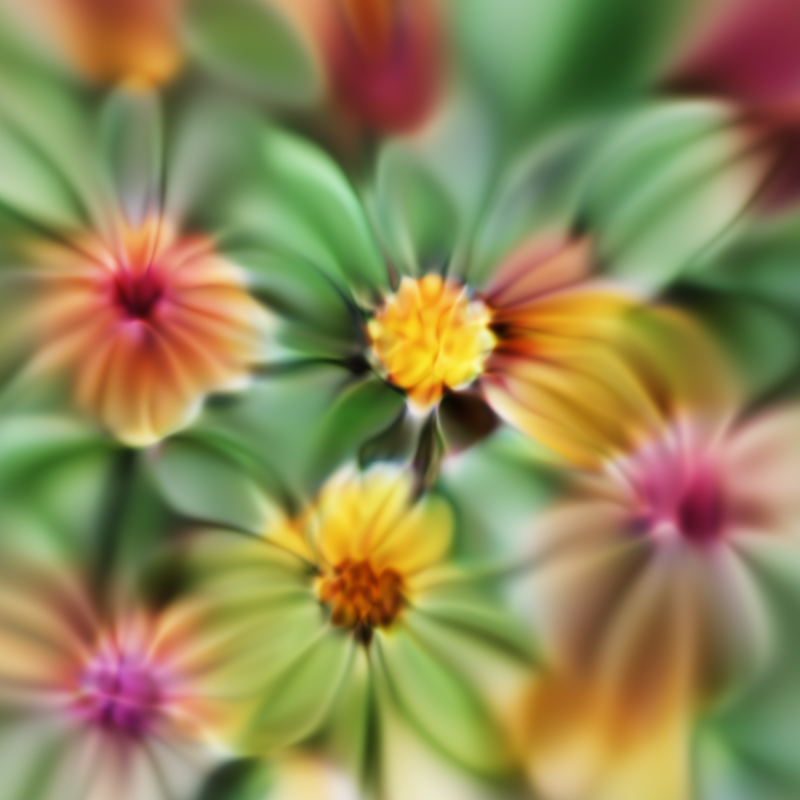

In [60]:
params = load('xy2rgb_mixed4b_pool_reduce_pre_relu_16.npy', allow_pickle=True)
vis = render_params(params, 800)
show(vis)


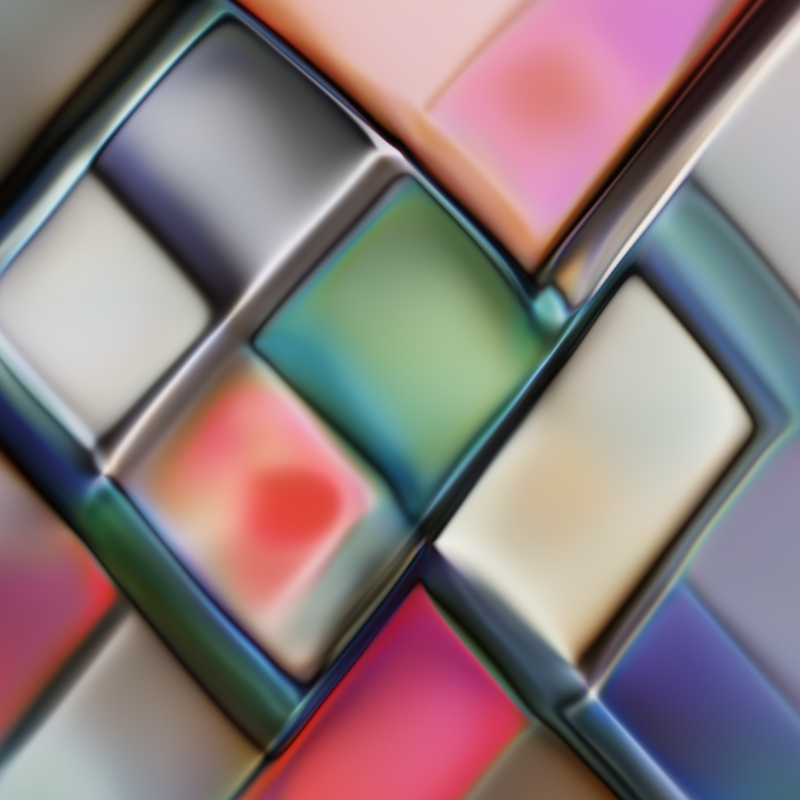

In [27]:
params = load('xy2rgb_mixed4a_pool_reduce_pre_relu_52.npy', allow_pickle=True)
vis = render_params(params, 800)
show(vis)

# Interpolating CPPN parameters

This requires you to have run the `render_story` method from the "Video of the training process" section—it saves out the learned parameters which we are interpolating between here.

In [61]:
def interpolate_params(param1, param2, duration=5.0, size=224):

  def frame(t):
    t = t / duration
    t = (1.0-np.cos(2.0*np.pi*t))/2.0       # looping & easing
    params = param1*(1.0-t) + param2*t      # blending
    params *= 1.0 + t*(1.0-t)               # exaggerating
    img = render_params(params, size=size)
    return _normalize_array(img)

  clip = mpy.VideoClip(frame, duration=duration)
  clip.write_videofile('tmp.mp4', fps=30.0)
  display(mpy.ipython_display('tmp.mp4', height=400))

In [62]:
interpolate_params(
    load('xy2rgb_mixed4b_pool_reduce_pre_relu_16.npy', allow_pickle=True),
    load('xy2rgb_mixed4a_pool_reduce_pre_relu_52.npy', allow_pickle=True),
)

Moviepy - Building video tmp.mp4.
Moviepy - Writing video tmp.mp4



Moviepy - Done !
Moviepy - video ready tmp.mp4
